![Alt text](image-3.png)

# Laboratorio 2 - Regresión
### Paula Daza Diaz - 202111276
### Juan Camilo Reyes - 201922989
### Sofia Torres Ramírez - 202014872

In [1]:
import numpy as np
import pandas as pd
import csv
import math

import statsmodels.api as sm

from joblib import dump, load

import matplotlib.pyplot as plt
import seaborn as sns

import ydata_profiling

from sklearn.impute import KNNImputer
from scipy.stats import linregress
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import scipy.stats as stats
%matplotlib inline

In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 50)

# 1. Entendimiento de los datos

## 1.1 Carga de los datos

Para inciar todo el proceso de regreción es importante tener un archivo de entrenamiento y otro de prueba. En este caso podemos ver las instrucciones para cargar estos dataframes llamados df_laptops y df_laptops_new

In [3]:
df_laptops = pd.read_csv('202320_Laboratorio 2 - Regresión_data_laptop_data_train.csv', sep=',', encoding = 'utf-8', index_col=0)

In [4]:
df_laptops_new = pd.read_csv('202320_Laboratorio 2 - Regresión_data_laptop_data_test_unlabeled.csv', sep=',', encoding = 'utf-8', index_col=0)

## 1.2 Descripción de datos

#### Data frame de entrenamiento

Como primera aproximación, se procede a realizar un análisis exploratorio de los datos. En este caso se quiso conocer el número de filas, columnas y datos que incluye el data frame hallando así los siguientes resultados.
| Número de filas | Número de columnas | Número total de datos |
|--------------|--------------|--------------|
| 1216 | 13 | 15808 |




In [5]:
df_laptops.shape

(1216, 13)

Luego se busca previsualizar los datos para tener un anticipo de los valor que nos podríamos encontrar en cada campo.


In [6]:
df_laptops.sample(5)

Company   TypeName  Ram  Weight       Price  TouchScreen  Ips  \
id                                                                   
510     Dell  Ultrabook    8    1.29   10.776844            1    1   
965     Dell   Notebook    4    2.25  302.137406            0    0   
928     Dell   Notebook    4    2.18   10.538090            0    0   
868     Acer   Notebook    8    1.56   10.780176            0    1   
1132    Asus   Notebook    4    1.50    9.603182            0    0   

             Ppi              Cpu_brand     HDD  SSD Gpu_brand       Os  
id                                                                       
510   165.632118          Intel Core i5     0.0  128     Intel  Windows  
965   100.454670          Intel Core i3  1000.0    0       AMD   Others  
928   100.454670          Intel Core i5  1000.0    0     Intel  Windows  
868   157.350512          Intel Core i5     0.0  256     Intel  Windows  
1132  111.935204  Other Intel Processor     0.0    0     Intel  Windows

Siguiente a esto se conoce el tipo de valor que contiene cada columna.

In [7]:
df_laptops.dtypes

Company         object
TypeName        object
Ram              int64
Weight         float64
Price          float64
TouchScreen      int64
Ips              int64
Ppi            float64
Cpu_brand       object
HDD            float64
SSD              int64
Gpu_brand       object
Os              object
dtype: object

A continuación se quieren conocer algunas medidas estadísticas descriptivas de los campos numéricos obteniendo así los siguientes resultados

In [8]:
df_laptops.describe()

Ram       Weight        Price  TouchScreen          Ips  \
count  1216.000000  1193.000000  1201.000000  1216.000000  1216.000000   
mean      8.458882     2.401572    13.114402     0.145559     0.285362   
std       5.094332     4.844791    28.659102     0.352809     0.451772   
min       2.000000     0.690000     9.134616     0.000000     0.000000   
25%       4.000000     1.500000    10.403650     0.000000     0.000000   
50%       8.000000     2.040000    10.882316     0.000000     0.000000   
75%       8.000000     2.320000    11.288115     0.000000     1.000000   
max      64.000000    97.729949   499.766079     1.000000     1.000000   

               Ppi           HDD          SSD  
count  1204.000000   1200.000000  1216.000000  
mean    183.830716    441.218800   187.529605  
std     449.708876    927.052855   186.902926  
min      90.583402      0.000000     0.000000  
25%     127.335675      0.000000     0.000000  
50%     141.211998      0.000000   256.000000  
75%     157.350512   1000.000000   256.000000  
max    7328.468865  24127.543112  1024.000000

#### Data frame de prueba

Como primera aproximación, se procede a realizar un análisis exploratorio de los datos. En este caso se quiso conocer el número de filas, columnas y datos que incluye el data frame hallando asei los siguientes resultados.
| Número de filas | Número de columnas | Número total de datos |
|--------------|--------------|--------------|
| 64 | 13 | 832 |


In [9]:
df_laptops_new.shape

(64, 13)

En este caso podemos ver que DataFrame de prueba es mucho más pequeño que el DataFrame de entrenamiento debido a que un DataFrame de entrenamiento más grande proporciona una base sólida para aprender y generalizar a partir de los datos, lo que puede llevar a un mejor rendimiento en datos nuevos y desconocidos. El DataFrame de prueba, en contraste, se mantiene más pequeño para evaluar imparcialmente la capacidad de generalización del modelo.

In [10]:
df_laptops_new.sample(5)

Company   TypeName  Ram  Weight  TouchScreen  Ips         Ppi  \
id                                                                    
43       Acer   Notebook    4    2.20            0    1  141.211998   
1021  Toshiba  Ultrabook    8    1.20            0    0  165.632118   
1088       HP   Notebook    4    1.29            0    0  276.053530   
1154     Dell   Notebook    8    2.04            1    1  282.423996   
978        HP   Notebook    6    2.04            0    0  100.454670   

                  Cpu_brand     HDD  SSD Gpu_brand       Os  CalculatedPrice  
id                                                                            
43            Intel Core i5     0.0  256     Intel  Windows              NaN  
1021          Intel Core i5     0.0  256     Intel  Windows              NaN  
1088  Other Intel Processor     0.0    0     Intel   Others              NaN  
1154          Intel Core i5     0.0  256    Nvidia  Windows              NaN  
978           Intel Core i7  1000.0    0     Intel  Windows              NaN

In [11]:
percentage_nan = df_laptops_new.isna().mean() * 100
print(percentage_nan)

Company              0.0000
TypeName             0.0000
Ram                  0.0000
Weight               1.5625
TouchScreen          0.0000
Ips                  0.0000
Ppi                  0.0000
Cpu_brand            0.0000
HDD                  0.0000
SSD                  0.0000
Gpu_brand            0.0000
Os                   0.0000
CalculatedPrice    100.0000
dtype: float64


Siguiente a esto se conoce el tipo de valor que contiene cada columna.

In [12]:
df_laptops.dtypes

Company         object
TypeName        object
Ram              int64
Weight         float64
Price          float64
TouchScreen      int64
Ips              int64
Ppi            float64
Cpu_brand       object
HDD            float64
SSD              int64
Gpu_brand       object
Os              object
dtype: object

Luego se busca previsualizar los datos para tener un anticipo de los valor que nos podríamos encontrar en cada campo.

In [13]:
df_laptops.describe()

Ram       Weight        Price  TouchScreen          Ips  \
count  1216.000000  1193.000000  1201.000000  1216.000000  1216.000000   
mean      8.458882     2.401572    13.114402     0.145559     0.285362   
std       5.094332     4.844791    28.659102     0.352809     0.451772   
min       2.000000     0.690000     9.134616     0.000000     0.000000   
25%       4.000000     1.500000    10.403650     0.000000     0.000000   
50%       8.000000     2.040000    10.882316     0.000000     0.000000   
75%       8.000000     2.320000    11.288115     0.000000     1.000000   
max      64.000000    97.729949   499.766079     1.000000     1.000000   

               Ppi           HDD          SSD  
count  1204.000000   1200.000000  1216.000000  
mean    183.830716    441.218800   187.529605  
std     449.708876    927.052855   186.902926  
min      90.583402      0.000000     0.000000  
25%     127.335675      0.000000     0.000000  
50%     141.211998      0.000000   256.000000  
75%     157.350512   1000.000000   256.000000  
max    7328.468865  24127.543112  1024.000000

Luego se crea un perfil en pandas del DataFrame de entrenamiento para poder tener una vista mucho más completa de los datos que se manejarán

In [14]:
!pip install pandas-profiling

In [15]:
import pandas_profiling

/var/folders/c3/74tsbvcd7f59g59y1gww3qk40000gn/T/ipykernel_91043/1591302161.py:1: DeprecationWarning: `import pandas_profiling` is going to be deprecated by April 1st. Please use `import ydata_profiling` instead.
  import pandas_profiling


In [16]:
profile = pandas_profiling.ProfileReport(df_laptops)

Como análisis general, se puede ver que hay 66 celdas que no tienen valor y 4 filas duplicadas.

Adicionalmente se puede ver que existen 8 alertas en donde a grandes razgos podeos encontrar que las columnas "weight", "price" y "HDD" tienen valores faltantes. Estos valores se tiene en cuenta más adelante en la seccieon de limpieza de datos.

In [17]:
profile

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Por último se crea un perfil en pandas del DataFrame de prueba para poder tener una vista mucho más completa de los datos que se manejarán

In [18]:
profile_new = pandas_profiling.ProfileReport(df_laptops_new)

Como análisis general, se puede ver que hay 65 celdas que no tienen valor y no hay filas duplicadas.

Adicionalmente se puede ver que existen 8 alertas en donde a grandes razgos podeos encontrar que las columnas "weight" y "CalculatedPrice" tienen valores faltantes. Estos valores se tiene en cuenta más adelante en la seccieon de limpieza de datos.

In [19]:
profile_new

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

# 2. Preparación de datos

Para poder trabajar sobre el DataFrame es necesario realizar una limpieza de datos completa. 

## 2.1 Limplieza de datos

Este proceso de limpieza se dividirá en 4 pasos: Completitud, Duplicidad, Consistencia y estadarización.

### 2.1.1 Eliminación de datos - completitud

Paa poder realizar este paso primero es necesario saber si hay filas con valores vacíos en donde se puede apreciar que para múltiples variables con un procentaje de valores vacíos que podría ser significativo.

In [20]:
(df_laptops.isna().sum() / df_laptops.shape[0]).sort_values(ascending = False)

Weight         0.018914
HDD            0.013158
Price          0.012336
Ppi            0.009868
Company        0.000000
TypeName       0.000000
Ram            0.000000
TouchScreen    0.000000
Ips            0.000000
Cpu_brand      0.000000
SSD            0.000000
Gpu_brand      0.000000
Os             0.000000
dtype: float64

Teniendo en cuenta que las 3 primeras variables ("Weight", "HDD" y "Price") poseen un porcentaje de valores vacíos mayor al 1%, en lugar de eliminar esos registros se cambia su valor por la mediana. 

En este fragemnto de código se busca cuales son las filas que tienen valor NaN para dar una idea de la cantidad de valores que se podrian esta manejando.

In [21]:
df_laptops.loc[df_laptops.Weight.isna()]

Company            TypeName  Ram  Weight       Price  TouchScreen  Ips  \
id                                                                            
737     Dell  2 in 1 Convertible    8     NaN  344.780371            1    0   
48      Dell            Notebook    4     NaN   10.435465            0    0   
69      Asus              Gaming   12     NaN   10.830970            0    0   
672   Lenovo  2 in 1 Convertible    8     NaN   10.916751            1    1   
1183    Acer            Notebook    4     NaN         NaN            0    0   
1202    Dell           Ultrabook   16     NaN  274.559205            1    0   
865       HP            Notebook    4     NaN   10.789006            0    0   
774       HP           Ultrabook    4     NaN   11.101648            0    0   
609     Acer            Notebook    4     NaN    9.830633            0    0   
220     Dell            Notebook    8     NaN   10.493749            0    0   
500     Asus             Netbook    4     NaN    9.804507            0    0   
733     Acer            Notebook    4     NaN   10.301710            0    0   
1003      HP            Notebook    4     NaN         NaN            0    0   
1108      HP            Notebook    4     NaN    9.962013            0    0   
483    Chuwi            Notebook    4     NaN    9.492612            0    0   
1127      HP           Ultrabook    8     NaN   11.522535            0    0   
1252  Lenovo            Notebook    8     NaN         NaN            0    1   
1205      HP            Notebook    8     NaN         NaN            0    0   
1007      HP           Ultrabook    8     NaN   11.254190            0    0   
393      MSI              Gaming    8     NaN  342.497973            0    0   
1168      HP            Notebook    2     NaN         NaN            0    0   
97      Dell            Notebook    4     NaN         NaN            0    0   
470       HP  2 in 1 Convertible    8     NaN   11.575963            1    1   

              Ppi              Cpu_brand           HDD  SSD Gpu_brand       Os  
id                                                                              
737    165.632118          Intel Core i5   1000.000000    0     Intel  Windows  
48            NaN          Intel Core i5      0.000000  256       AMD  Windows  
69            NaN          Intel Core i7   1000.000000    0    Nvidia   Others  
672    165.632118          Intel Core i5      0.000000  256     Intel  Windows  
1183          NaN  Other Intel Processor  12675.017162    0     Intel  Windows  
1202   276.053530          Intel Core i7      0.000000  512   Intel%%  Windows  
865           NaN          Intel Core i5    500.000000    0     Intel  Windows  
774    125.367428          Intel Core i5      0.000000  256     Intel  Windows  
609   2997.580634  Other Intel Processor      0.000000    0     Intel  Windows  
220    141.211998          Intel Core i5      0.000000  256       AMD   Others  
500           NaN  Other Intel Processor      0.000000    0     Intel  Windows  
733           NaN          Intel Core i5    500.000000    0     Intel  Windows  
1003   111.935204          Intel Core i5  24127.543112    0     Intel  Windows  
1108   141.211998          AMD Processor   1000.000000    0       AMD  Windows  
483    141.211998  Other Intel Processor      0.000000    0     Intel  Windows  
1127          NaN          Intel Core i5           NaN  256     Intel  Windows  
1252   157.350512          Intel Core i5      0.000000  256     Intel  Windows  
1205  2071.670319          Intel Core i5      0.000000  256     Intel  Windows  
1007  4947.212947          Intel Core i7           NaN  256     Intel  Windows  
393    127.335675          Intel Core i7      0.000000  256    Nvidia  Windows  
1168   111.935204  Other Intel Processor      0.000000    0     Intel  Windows  
97    5141.291969          Intel Core i3           NaN  256       AMD   Others  
470    331.264236          Intel Core i7      0.000000  512     Intel  Windows

Todos los valores de la columna Weight que tuvieran valor de NaN se reemplazaron por la mediana

In [22]:
median_weight = df_laptops['Weight'].median()
df_laptops['Weight'].fillna(median_weight, inplace=True)

In [23]:
df_laptops.loc[df_laptops.Weight.isna()]

Empty DataFrame
Columns: [Company, TypeName, Ram, Weight, Price, TouchScreen, Ips, Ppi, Cpu_brand, HDD, SSD, Gpu_brand, Os]
Index: []

Todos los valores de la columna HDD que tuvieran valor de NaN se reemplazaron por la mediana

In [24]:
median_HDD = df_laptops['HDD'].median()
df_laptops['HDD'].fillna(median_HDD, inplace=True)

In [25]:
df_laptops.loc[df_laptops.HDD.isna()]

Empty DataFrame
Columns: [Company, TypeName, Ram, Weight, Price, TouchScreen, Ips, Ppi, Cpu_brand, HDD, SSD, Gpu_brand, Os]
Index: []

Todos los valores de la columna Price que tuvieran valor de NaN se reemplazaron por la mediana

In [26]:
median_price = df_laptops['Price'].median()
df_laptops['Price'].fillna(median_price, inplace=True)

In [27]:
df_laptops.loc[df_laptops.Price.isna()]

Empty DataFrame
Columns: [Company, TypeName, Ram, Weight, Price, TouchScreen, Ips, Ppi, Cpu_brand, HDD, SSD, Gpu_brand, Os]
Index: []

Teniendo en cuenta que el porcentaje de valores vacios en la columna Ppi es menor al 1% se eliminan estos registros

In [28]:
df_laptops.dropna(subset=['Ppi'], inplace=True)

In [29]:
df_laptops = df_laptops[df_laptops['Ppi'] != 'NaN']

Luego se verifica que ya no existen valores vacios en el dataframe

In [30]:
(df_laptops.isna().sum() / df_laptops.shape[0]).sort_values(ascending = False)

Company        0.0
TypeName       0.0
Ram            0.0
Weight         0.0
Price          0.0
TouchScreen    0.0
Ips            0.0
Ppi            0.0
Cpu_brand      0.0
HDD            0.0
SSD            0.0
Gpu_brand      0.0
Os             0.0
dtype: float64

En los datos de prueba también hay valores nulos, por lo que se les aplicará el mismo tratamiento:

In [31]:
(df_laptops_new.isna().sum() / df_laptops.shape[0]).sort_values(ascending = False)

CalculatedPrice    0.053156
Weight             0.000831
Company            0.000000
TypeName           0.000000
Ram                0.000000
TouchScreen        0.000000
Ips                0.000000
Ppi                0.000000
Cpu_brand          0.000000
HDD                0.000000
SSD                0.000000
Gpu_brand          0.000000
Os                 0.000000
dtype: float64

Teniendo en cuenta que la columna 'CalculatedPrice' es la columna que se va a rellenar con los valores predecidos más adelante, nos enfocamos en la columna Weight y buscamos cuales son las filas en donde esta columna tiene valores nulos.

In [118]:
df_laptops_new.loc[df_laptops_new.Weight.isna()]

Empty DataFrame
Columns: [Company, TypeName, Ram, Weight, TouchScreen, Ips, Ppi, Cpu_brand, HDD, SSD, Gpu_brand, Os, CalculatedPrice]
Index: []

Teniendo en cuenta que el porcentaje de valores nulos en esta columna es menor al 1% se eliminan estos valores

In [33]:
df_laptops_new.dropna(subset=['Weight'], inplace=True)

In [34]:
df_laptops_new = df_laptops_new[df_laptops_new['Weight'] != 'NaN']

### 2.1.2 Duplicidad

En este momento se busca encontrar campos con valores duplicados. En este caso los campos que podrían indicar una duplicidad de datos serían los campos que representan índices de cada laptop

In [37]:
duplicates = df_laptops.duplicated()
num_duplicates = duplicates.sum()
print("Number of duplicates: ", num_duplicates)

Number of duplicates:  6


Se encontraron 6 duplicados, se porcede a eliminarlos

In [38]:
df_laptops = df_laptops.drop_duplicates()

In [39]:
duplicates = df_laptops.duplicated()
num_duplicates = duplicates.sum()
print("Number of duplicates: ", num_duplicates)

Number of duplicates:  0


Ahora se hace lo mismo con el data frame de prueba

In [40]:
duplicates = df_laptops_new.duplicated()
num_duplicates = duplicates.sum()
print("Number of duplicates: ", num_duplicates)

Number of duplicates:  0


Luego de este análisis ya no se encuentran datos duplicados. Sin embargo, esto puede cambiar a la hora de reemplazar los outliers.

### 2.1.3 Consistencia

#### 2.1.3.1 Categóricos

Para todas las variables no numericas (aparte del titulo y demás campos que puedan representar un valor único) se busca saber qué tipos de valores podría tomar.

In [41]:
df_laptops['Company'].value_counts()

Company
Lenovo       275
Dell         274
HP           252
Asus         138
Acer          94
MSI           50
Toshiba       45
Apple         21
Samsung        8
Razer          7
Microsoft      6
Mediacom       6
Xiaomi         4
Vero           4
Fujitsu        3
Chuwi          3
LG             3
Google         3
Huawei         2
Name: count, dtype: int64

En el caso de la columna 'TypeName' se encontraron valores que estaban mal escritos pertenecientes a los valores de "Notebook", "Gaming", "2 in 1 Convertible" y "Ultrabook".

In [42]:
df_laptops['TypeName'].value_counts()

TypeName
Notebook                647
Gaming                  188
Ultrabook               183
2 in 1 Convertible      107
Workstation              28
Netbook                  20
Notebook%%                9
&&Notebook                5
Gaming%%                  4
&&Gaming                  3
&&2 in 1 Convertible      2
2 in 1 Convertible%%      1
&&Ultrabook               1
Name: count, dtype: int64

Se procede a cambiar cada uno de estos valores por su valor real.

In [43]:
df_laptops['TypeName'] = df_laptops['TypeName'].replace(['Notebook%%', '&&Notebook'], 'Notebook')

In [44]:
df_laptops['TypeName'] = df_laptops['TypeName'].replace(['Gaming%%', '&&Gaming'], 'Gaming')

In [45]:
df_laptops['TypeName'] = df_laptops['TypeName'].replace(['&&2 in 1 Convertible', '2 in 1 Convertible%%'], '2 in 1 Convertible')

In [46]:
df_laptops['TypeName'] = df_laptops['TypeName'].replace(['&&Ultrabook'], 'Ultrabook')

Se verifica que estos cambios hayan sido realizados.

In [47]:
df_laptops['TypeName'].value_counts()

TypeName
Notebook              661
Gaming                195
Ultrabook             184
2 in 1 Convertible    110
Workstation            28
Netbook                20
Name: count, dtype: int64

In [48]:
df_laptops['TouchScreen'].value_counts()

TouchScreen
0    1024
1     174
Name: count, dtype: int64

In [49]:
df_laptops['Ips'].value_counts()

Ips
0    858
1    340
Name: count, dtype: int64

In [50]:
df_laptops['Cpu_brand'].value_counts()

Cpu_brand
Intel Core i7            491
Intel Core i5            395
Intel Core i3            127
Other Intel Processor    127
AMD Processor             58
Name: count, dtype: int64

In [51]:
df_laptops['Os'].value_counts()

Os
Windows    1035
Others      142
Mac          21
Name: count, dtype: int64

Ahora se hace lo mismo pero para el data frame de prueba

In [52]:
df_laptops_new['Company'].value_counts()

Company
Dell        14
HP          13
Lenovo      13
Asus        10
Acer         5
MSI          4
Toshiba      3
Mediacom     1
Name: count, dtype: int64

En este DataFrame también se encuntran valores mal escritos, en este caso solo se presenta en el valor de "Notebook".

In [53]:
df_laptops_new['TypeName'].value_counts()

TypeName
Notebook              37
Gaming                 9
Ultrabook              8
2 in 1 Convertible     6
Netbook                2
&&Notebook             1
Name: count, dtype: int64

Se procede a cambiar estos valores

In [54]:
df_laptops_new['TypeName'] = df_laptops['TypeName'].replace(['&&Notebook'], 'Notebook')

In [55]:
df_laptops_new['TypeName'].value_counts()

TypeName
2 in 1 Convertible    1
Name: count, dtype: int64

In [56]:
df_laptops_new['Cpu_brand'].value_counts()

Cpu_brand
Intel Core i7            22
Intel Core i5            21
Other Intel Processor    11
Intel Core i3             7
AMD Processor             2
Name: count, dtype: int64

In [57]:
df_laptops_new['Gpu_brand'].value_counts()

Gpu_brand
Intel     35
Nvidia    20
AMD        8
Name: count, dtype: int64

In [58]:
df_laptops_new['Os'].value_counts()

Os
Windows    55
Others      8
Name: count, dtype: int64

#### 2.1.3.2 Numéricos

Para todas variables numéricas se busca que sus valores no esten tan alejados el uno del otro

En este caso se puede que que en la mayoría de variables numéricas existen valores atípicos.

In [59]:
df_laptops.describe()

Ram       Weight        Price  TouchScreen          Ips  \
count  1198.000000  1198.000000  1198.000000  1198.000000  1198.000000   
mean      8.469115     2.326267    13.120333     0.145242     0.283806   
std       5.096591     4.465103    28.694639     0.352492     0.451032   
min       2.000000     0.690000     9.134616     0.000000     0.000000   
25%       4.000000     1.510000    10.410635     0.000000     0.000000   
50%       8.000000     2.040000    10.882316     0.000000     0.000000   
75%       8.000000     2.310000    11.288115     0.000000     1.000000   
max      64.000000    97.729949   499.766079     1.000000     1.000000   

               Ppi           HDD          SSD  
count  1198.000000   1198.000000  1198.000000  
mean    183.789473    428.036347   188.524207  
std     450.807481    857.622970   186.927152  
min      90.583402      0.000000     0.000000  
25%     127.335675      0.000000     0.000000  
50%     141.211998      0.000000   256.000000  
75%     157.350512   1000.000000   256.000000  
max    7328.468865  24127.543112  1024.000000

En esta instrucción para las variables numéricas no categóricas basandose en el rango intercuartílico, consierando como valor atípico todo aquel valor que esté por debajo del valor del 25% de los datos y por arriba del 75% de los datos.

In [60]:
columnas_a_procesar = ['Ram', 'Weight', 'Price', 'Ppi', 'HDD', 'SSD']

for columna in columnas_a_procesar:
    primer_cuartil = df_laptops[columna].quantile(0.25)
    tercer_cuartil = df_laptops[columna].quantile(0.75)
    mediana = df_laptops[columna].median()
    
    df_laptops[columna] = np.where((df_laptops[columna] < primer_cuartil) | (df_laptops[columna] > tercer_cuartil), mediana, df_laptops[columna])





Luego se verifica que los cambios hayan sifo efectuados correctamente.

In [61]:
df_laptops.describe()

Ram       Weight        Price  TouchScreen          Ips  \
count  1198.000000  1198.000000  1198.000000  1198.000000  1198.000000   
mean      6.809683     2.025535    10.881038     0.145242     0.283806   
std       1.799148     0.147994     0.175229     0.352492     0.451032   
min       4.000000     1.540000    10.419692     0.000000     0.000000   
25%       4.000000     2.040000    10.882316     0.000000     0.000000   
50%       8.000000     2.040000    10.882316     0.000000     0.000000   
75%       8.000000     2.040000    10.882316     0.000000     1.000000   
max       8.000000     2.310000    11.288115     1.000000     1.000000   

               Ppi          HDD          SSD  
count  1198.000000  1198.000000  1198.000000  
mean    141.238267   359.482471   150.360601  
std       6.896166   454.213254   116.463383  
min     127.335675     0.000000     0.000000  
25%     141.211998     0.000000     0.000000  
50%     141.211998     0.000000   256.000000  
75%     141.211998  1000.000000   256.000000  
max     157.350512  1000.000000   256.000000

Ahora se hace lo mismo para el dataframe de prueba

En este caso se puede que que en la mayoría de variables numéricas existen valores atípicos.

In [62]:
df_laptops_new.describe()

Ram     Weight  TouchScreen        Ips         Ppi          HDD  \
count  63.000000  63.000000    63.000000  63.000000   63.000000    63.000000   
mean    8.507937   2.002857     0.190476   0.238095  154.883423   500.000000   
std     5.423584   0.618170     0.395831   0.429339   51.980062   575.017531   
min     2.000000   0.690000     0.000000   0.000000   90.583402     0.000000   
25%     4.000000   1.550000     0.000000   0.000000  127.335675     0.000000   
50%     8.000000   2.020000     0.000000   0.000000  141.211998     0.000000   
75%     8.000000   2.265000     0.000000   0.000000  161.491315  1000.000000   
max    32.000000   4.300000     1.000000   1.000000  316.965060  2000.000000   

               SSD  CalculatedPrice  
count    63.000000              0.0  
mean    164.190476              NaN  
std     184.184240              NaN  
min       0.000000              NaN  
25%       0.000000              NaN  
50%     128.000000              NaN  
75%     256.000000              NaN  
max    1000.000000              NaN

En esta instrucción para las variables numéricas no categóricas basandose en el rango intercuartílico, consierando como valor atípico todo aquel valor que esté por debajo del valor del 25% de los datos y por arriba del 75% de los datos.

In [63]:
columnas_a_procesar = ['Ram', 'Weight', 'HDD', 'SSD', 'Ppi']

for columna in columnas_a_procesar:
    primer_cuartil = df_laptops_new[columna].quantile(0.25)
    tercer_cuartil = df_laptops_new[columna].quantile(0.75)
    mediana = df_laptops_new[columna].median()
    
    df_laptops_new[columna] = np.where((df_laptops_new[columna] < primer_cuartil) | (df_laptops_new[columna] > tercer_cuartil), mediana, df_laptops_new[columna])



Luego se verifica que los cambios hayan sifo efectuados correctamente.

In [64]:
df_laptops_new.describe()

Ram     Weight  TouchScreen        Ips         Ppi          HDD  \
count  63.000000  63.000000    63.000000  63.000000   63.000000    63.000000   
mean    6.793651   1.993810     0.190476   0.238095  141.648455   404.761905   
std     1.815335   0.137365     0.395831   0.429339    7.338814   473.977191   
min     4.000000   1.600000     0.000000   0.000000  127.335675     0.000000   
25%     4.000000   2.020000     0.000000   0.000000  141.211998     0.000000   
50%     8.000000   2.020000     0.000000   0.000000  141.211998     0.000000   
75%     8.000000   2.020000     0.000000   0.000000  141.211998  1000.000000   
max     8.000000   2.230000     1.000000   1.000000  157.350512  1000.000000   

              SSD  CalculatedPrice  
count   63.000000              0.0  
mean   125.968254              NaN  
std    116.073109              NaN  
min      0.000000              NaN  
25%      0.000000              NaN  
50%    128.000000              NaN  
75%    256.000000              NaN  
max    256.000000              NaN

### 2.2 Identificación de variables a utilizar

### Correlación de variables con Precio

Para entrenar un modelo de regresión todas las variables de entrada (features) deben ser numéricas. Se seleccionan las variables numéricas que se consideran más importantes para la estimación de la variable objetivo (target) 'precio'.

In [65]:
features = ['Weight','Ram','Ips','Ppi','TouchScreen','HDD','SSD']

calcular la proporción de valores nulos en el daframe

In [66]:
df_laptops[['Price']+features].isnull().sum() / df_laptops.shape[0]

Price          0.0
Weight         0.0
Ram            0.0
Ips            0.0
Ppi            0.0
TouchScreen    0.0
HDD            0.0
SSD            0.0
dtype: float64

In [67]:
df_laptops = df_laptops.dropna(subset=["Price"]+features)

In [68]:
df_laptops.shape

(1198, 13)

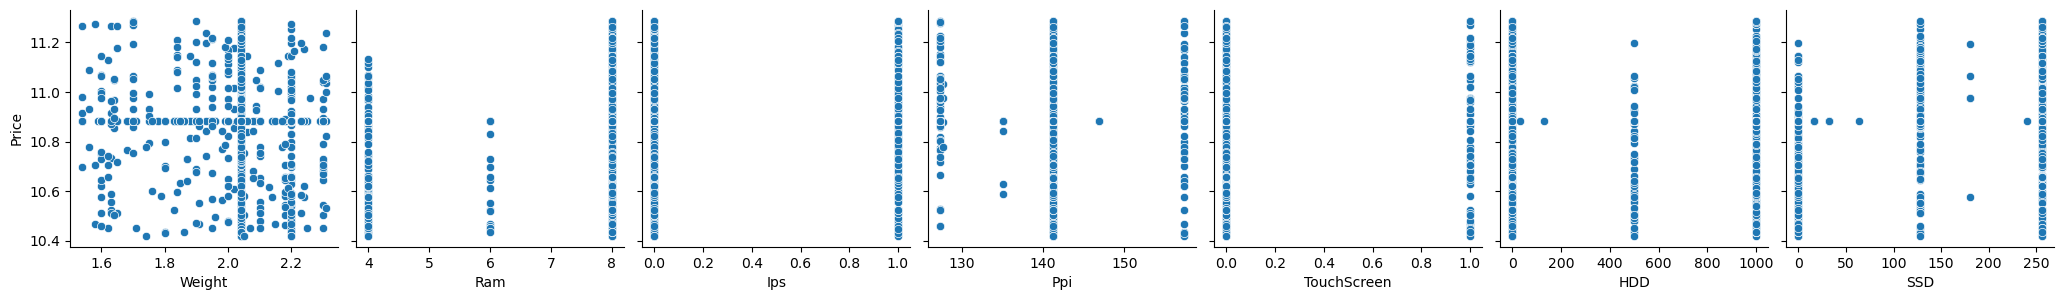

In [69]:
# Crear el gráfico
sns.pairplot(df_laptops, height=3, y_vars="Price", x_vars=features, kind="scatter", diag_kind="bar")

# Mostrar el gráfico
plt.show()


<Axes: >

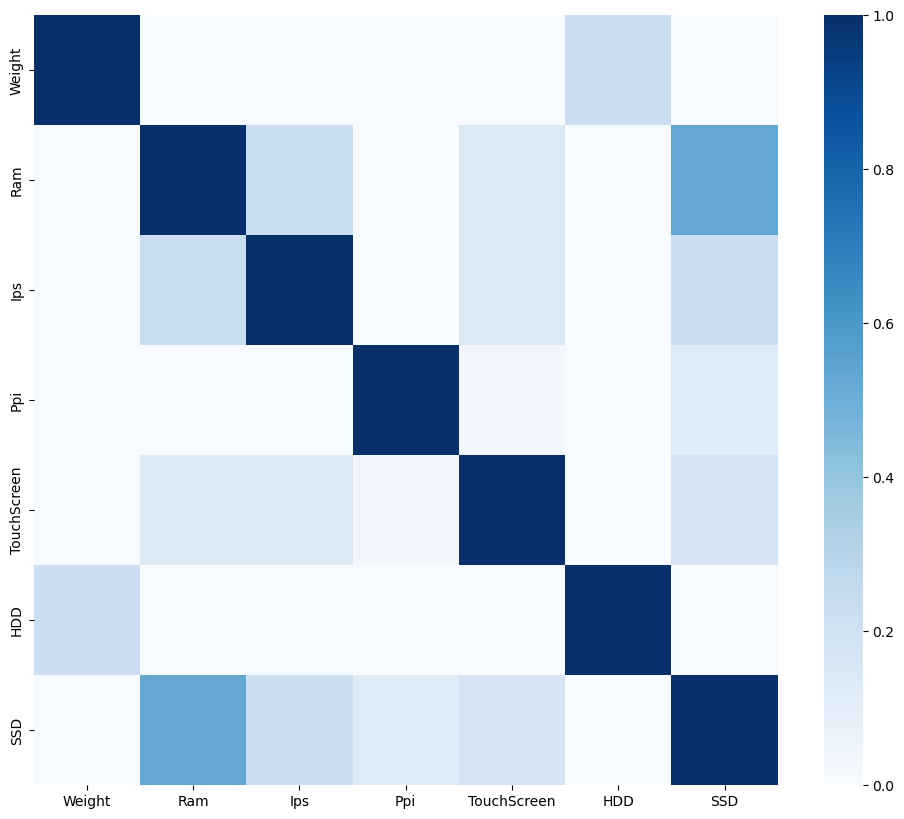

In [70]:
plt.figure(figsize=(12, 10))
sns.heatmap(df_laptops[features].corr(), cmap='Blues', vmin=0, vmax=1)

In [71]:
df_laptops[features].corr()

Weight       Ram       Ips       Ppi  TouchScreen       HDD  \
Weight       1.000000 -0.011192 -0.027296 -0.282995    -0.047597  0.224111   
Ram         -0.011192  1.000000  0.237517 -0.044065     0.133201 -0.077190   
Ips         -0.027296  0.237517  1.000000 -0.000265     0.134614 -0.072147   
Ppi         -0.282995 -0.044065 -0.000265  1.000000     0.032972 -0.322951   
TouchScreen -0.047597  0.133201  0.134614  0.032972     1.000000 -0.219413   
HDD          0.224111 -0.077190 -0.072147 -0.322951    -0.219413  1.000000   
SSD         -0.166038  0.524559  0.220198  0.118957     0.179025 -0.499086   

                  SSD  
Weight      -0.166038  
Ram          0.524559  
Ips          0.220198  
Ppi          0.118957  
TouchScreen  0.179025  
HDD         -0.499086  
SSD          1.000000

# 3. Modelamiento

Se realiza el partimiento de los datos de prueba y entrenamiento, se utiliza un valor de 30/70

In [72]:
X_train, X_test, y_train, y_test = train_test_split(df_laptops[features], df_laptops['Price'], test_size=0.3, random_state=1)

In [73]:
X_train.shape, y_train.shape

((838, 7), (838,))

In [74]:
X_test.shape, y_test.shape

((360, 7), (360,))

## 3.1 Entrenamiento del primer modelo

Utilizando el modelo de sklearn

In [75]:
regression = LinearRegression()

In [76]:
regression.fit(X_train, y_train)

LinearRegression()

### 3.1.1 Interpretacion de los coeficientes del intercepto

In [77]:
pd.DataFrame({'columns': features, 'coef': regression.coef_})

columns      coef
0       Weight -0.024505
1          Ram  0.010116
2          Ips  0.007009
3          Ppi -0.000380
4  TouchScreen -0.013518
5          HDD  0.000026
6          SSD  0.000394

Se utiliza el intercepto para determinar le valor base de la estimacion, en este caso el valor de Price base seria 9.714937644449606

In [78]:
regression.intercept_

10.848269753308895

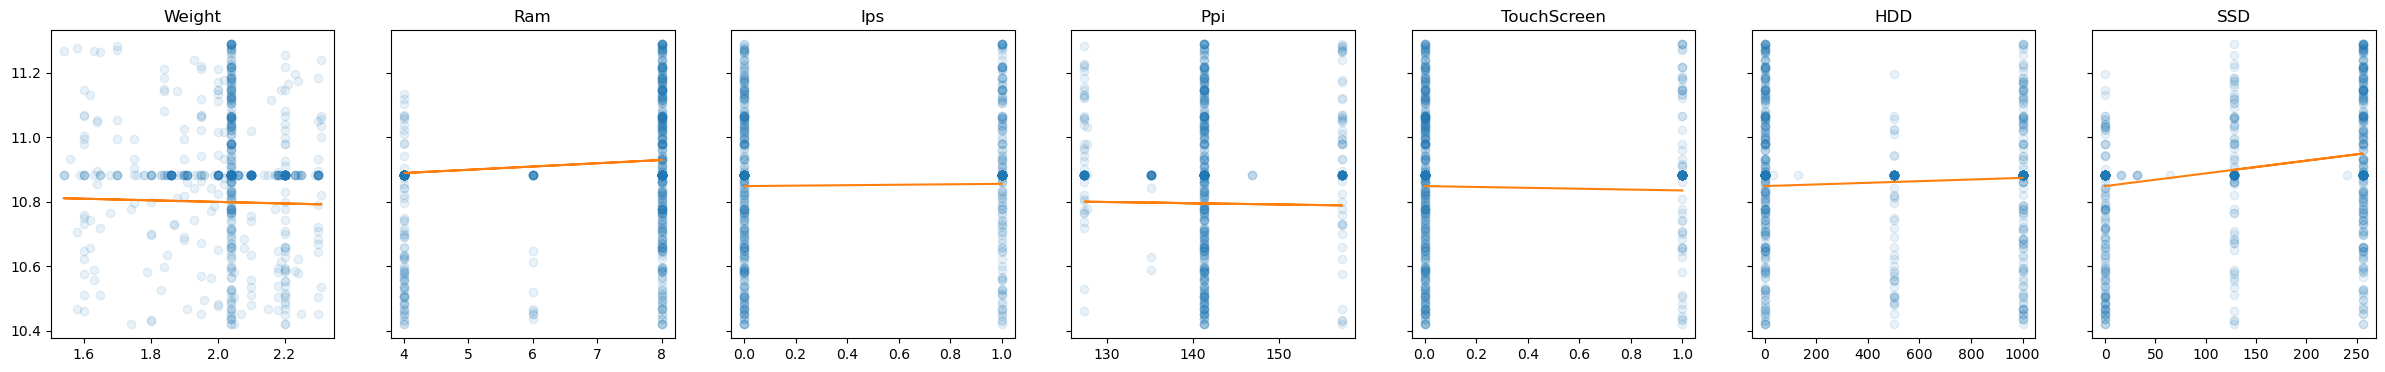

In [79]:
f, axs = plt.subplots(1, len(features), sharey=True,figsize=(30, 4))

for i in range(len(features)):
    col = features[i]
    x = X_train[col]
    m = regression.coef_[i]
    b = regression.intercept_

    axs[i].plot(x, y_train, 'o', alpha=0.1)
    axs[i].plot(x, x*m+b)
    axs[i].set_title(col)


Se realiza un grafico de la correlacion entre las features y el precio de un laptop, se traza una linea que utiliza los coeficientes del modelo para estimar el precio de un laptop y el intercepto para determinar el valor base de la estimacion

### 3.1.2 Validacion del modelo

Se realiza una estimacion del error cuadratico medio y el error absoluto medio utilizando tanto los datos de entrenamiento como los de prueba

**Mean Absolute Error (MAE)**

$$ MAE = {1 \over n}{\sum_{i=1}^n {|y_{i} - y_{i}'|} } $$

In [80]:
print('Train', mean_absolute_error(y_train, regression.predict(X_train)))
print('Test', mean_absolute_error(y_test, regression.predict(X_test)))

Train 0.12676134167751169
Test 0.1236641275568021


**Root Mean Squeared Error (RMSE)**

$$ RMSE = {1 \over n}{\sum_{i=1}^n {(y_{i} - y_{i}')^2} } $$

In [81]:
print('Train:', np.sqrt(mean_squared_error(y_train, regression.predict(X_train))))
print('Test:', np.sqrt(mean_squared_error(y_test, regression.predict(X_test))))

Train: 0.16809563625756688
Test: 0.16537837639136874


Se debe tener en cuenta que el modelo presenta errores significativos ya que no se han cumplido los supuestos de normalizacion y homocedasticidad los cuales disminuyen la influencia de los datos outliers en el modelo y por lo tanto disminuyen el error

<b> Analisis del error<b> 

El diagrama de caja muestra la distribucion de los datos, no es posible apreciar que la mediana es 14 porque existen valores atipicos que llegan hasta 500 que disminuyen la resolucion del grafico

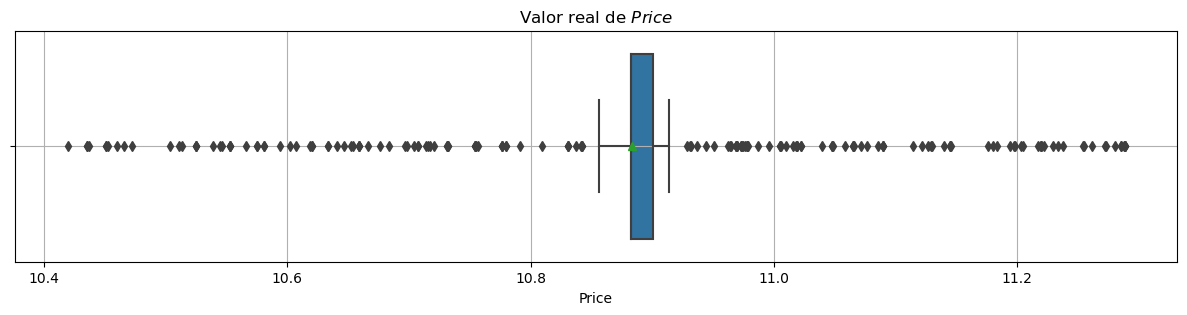

In [82]:
plt.figure(figsize = (15, 3))
sns.boxplot(x = y_test, showmeans = True, orient = 'h')
plt.title('Valor real de $\t{Price}$')
plt.grid()
plt.show()

In [83]:
y_test.describe()

count    360.000000
mean      10.883094
std        0.171073
min       10.419692
25%       10.882316
50%       10.882316
75%       10.900662
max       11.288115
Name: Price, dtype: float64

Es posible evidenciar el impacto que tienen los valores atipicos en el modelo, ya que la media se encuentra 14 pero el maximo se encuentra el 499

El diagrama de caja muestra la distribucion del error absoluto, es posible apreciar de nuevo que los datos atipicos en los datos entregados

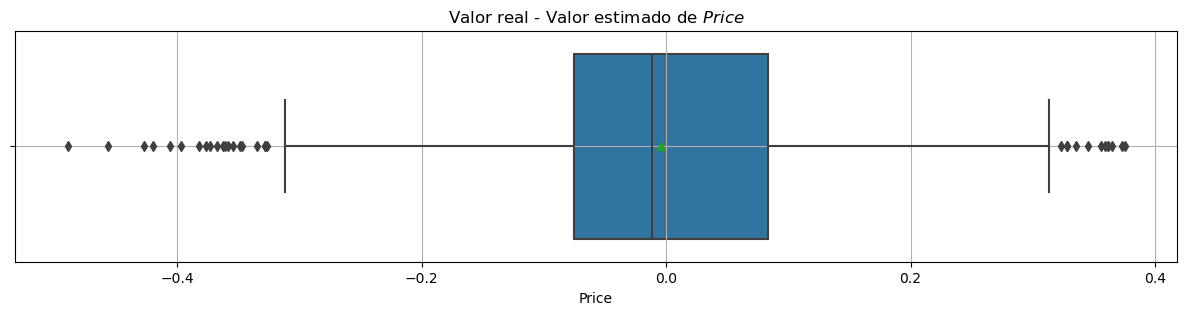

In [84]:
plt.figure(figsize = (15, 3))
sns.boxplot(x = (y_test - regression.predict(X_test)), showmeans = True, orient = 'h')
plt.title('Valor real - Valor estimado de $\t{Price}$')
plt.grid()
plt.show()

En este caso se obtiene que el modelo presenta fallas muy grandes en la prediccion de los precios de los laptops, ambos errores son elevados por lo que se infiere que hay un error de subajuste en el modelo y es necesario realizar mas transformaciones a los datos para disminuir el error de entrenamiento y consecutivamente en el prueba

## 3.2 Entrenamiento del segundo modelo

Se realiza el entrenamiento de un segundo modelo utilizando pipelines<br>
Este implementa StandardScaler, una funcion que en un primer paso estandariza los datos<br>
Luego LinearRegression los entrena con un modelo de regresion lineal

In [85]:
pipeline = Pipeline ([
    ('scaler', StandardScaler()),
    ('model', LinearRegression())
])

In [86]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()), ('model', LinearRegression())])

In [87]:
pd.DataFrame({'columns': features, 'coef': pipeline['model'].coef_})

columns      coef
0       Weight -0.003620
1          Ram  0.018392
2          Ips  0.003180
3          Ppi -0.002534
4  TouchScreen -0.004909
5          HDD  0.011438
6          SSD  0.046577

In [88]:
pipeline['model'].intercept_

10.88015500582686

El intercepto del modelo es 9.714937644449606, es decir se espera que el precio de un laptop sea aproximadamente de 9.715 cuando todos las variables del modelo son iguales a cero.

<b>MAE<b>

In [89]:
print('Train:', mean_absolute_error(y_train, pipeline.predict(X_train)))
print('Test:', mean_absolute_error(y_test, pipeline.predict(X_test)))


Train: 0.12676134167751174
Test: 0.12366412755680214


<b>RMSE<b>

In [90]:
print('Train:', np.sqrt(mean_squared_error(y_train, pipeline.predict(X_train))))
print('Test:', np.sqrt(mean_squared_error(y_test, pipeline.predict(X_test))))

Train: 0.16809563625756682
Test: 0.1653783763913687


El error no ha disminuido significativamente, por lo que se infiere que el modelo sigue presentando un error de subajuste y es necesario agregar mas pasos al pipeline

## 3.3 Validación de supuestos de la regresión lineal

### 3.3.1 Colinealidad

Se buscan columnas con muy alta o baja correlacion para separarlas ya que estas afectaran el modelo

<Axes: >

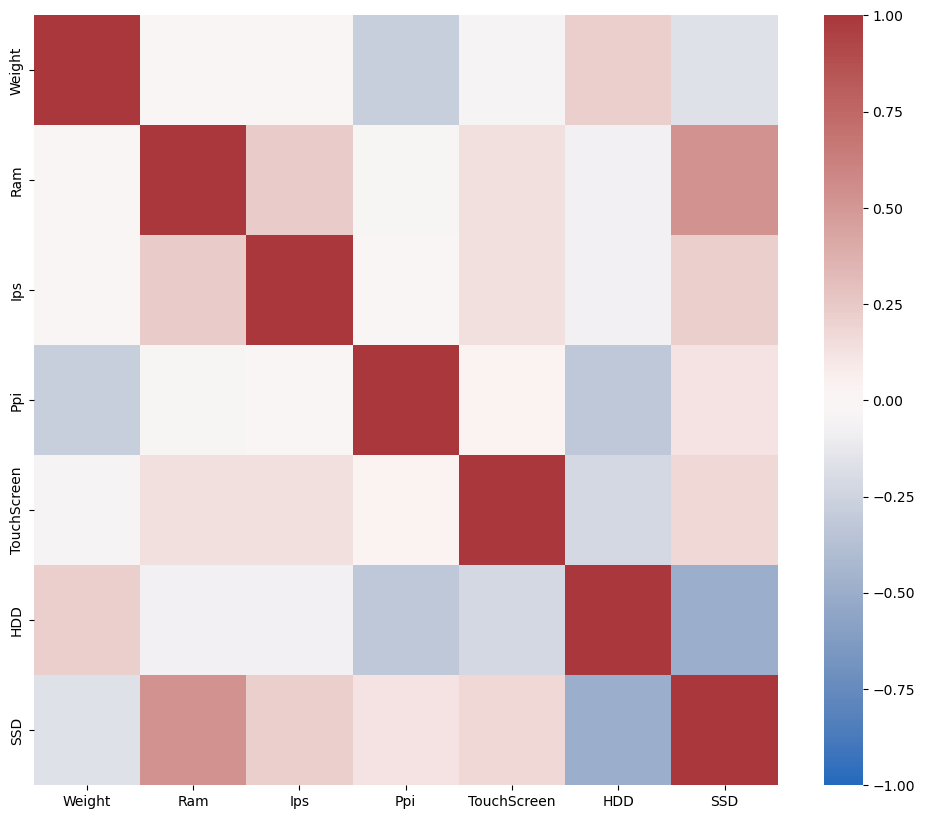

In [91]:
plt.figure(figsize = (12, 10))
sns.heatmap(df_laptops[features].corr(), cmap = 'vlag', vmin = -1, vmax = 1)

In [92]:
df_laptops[features].corr()

Weight       Ram       Ips       Ppi  TouchScreen       HDD  \
Weight       1.000000 -0.011192 -0.027296 -0.282995    -0.047597  0.224111   
Ram         -0.011192  1.000000  0.237517 -0.044065     0.133201 -0.077190   
Ips         -0.027296  0.237517  1.000000 -0.000265     0.134614 -0.072147   
Ppi         -0.282995 -0.044065 -0.000265  1.000000     0.032972 -0.322951   
TouchScreen -0.047597  0.133201  0.134614  0.032972     1.000000 -0.219413   
HDD          0.224111 -0.077190 -0.072147 -0.322951    -0.219413  1.000000   
SSD         -0.166038  0.524559  0.220198  0.118957     0.179025 -0.499086   

                  SSD  
Weight      -0.166038  
Ram          0.524559  
Ips          0.220198  
Ppi          0.118957  
TouchScreen  0.179025  
HDD         -0.499086  
SSD          1.000000

Se observa que no hay una alta colinealidad entre las variables por lo tanto no es necesario realizar un estudio adicional

### 3.3.2 Linealidad

Se observa si el feature y el valor de "price" tienen una relacion lineal<br>

Para encontrar esta relacion se grafican el comportamiento de las variables junto con una linea que representa las tendencias lineales de los datos<br>

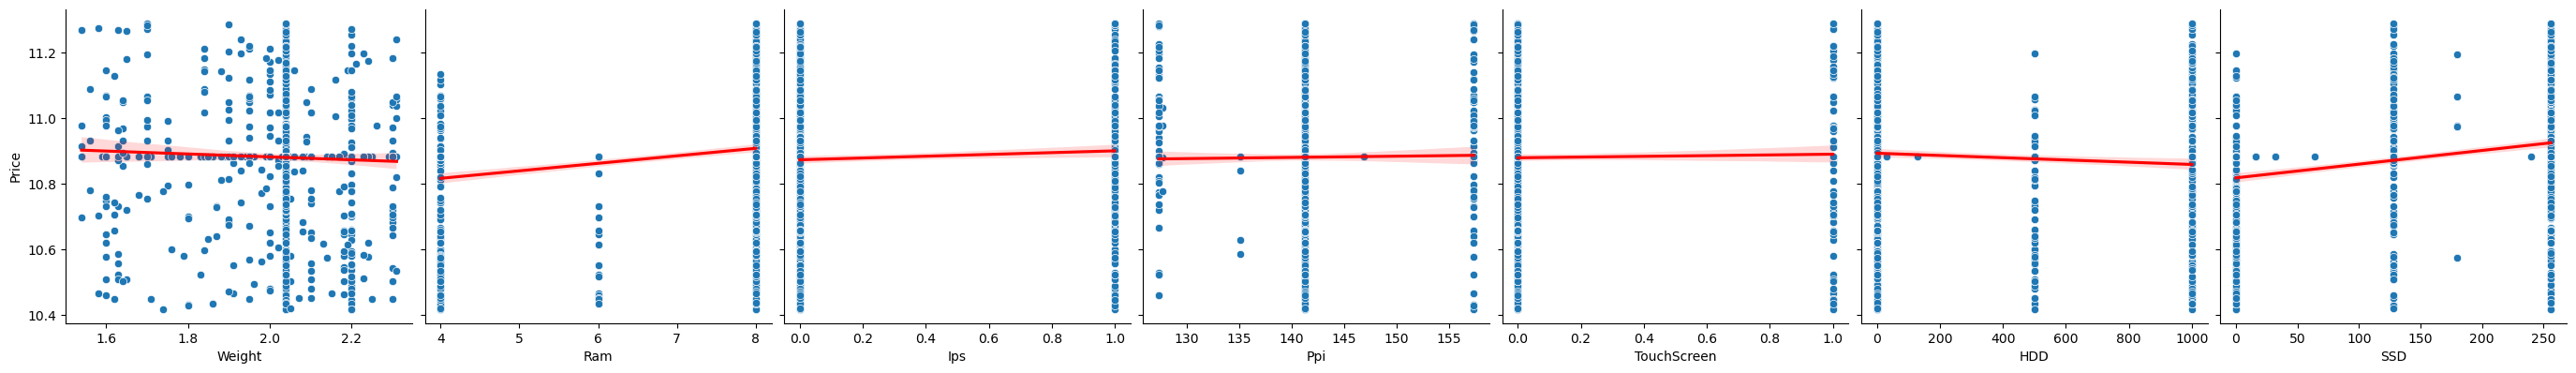

In [93]:
sns.pairplot(df_laptops, height = 4, y_vars = 'Price', x_vars = features, kind = 'scatter')
for i, ax in enumerate(plt.gcf().axes):
    if i % len(features) == 0:
        ax.yaxis.label.set_visible(True)
    sns.regplot(data=df_laptops, x=features[i % len(features)], y='Price', scatter=False, line_kws={'color': 'red'}, ax=ax)

plt.show()

En un analisis inicial es posible observar como los datos atipicos afectan la linearidad del modelo

Al calcular $R^2$ se indicara cual es la proporcion de la varianza de la variable dependiente que es explicada por la variable independiente en el modelo de regresion lineal

<b>$R^2$<b>

In [94]:
r_squared = pipeline.score(X_test[features], y_test)
print (r_squared)

0.06286374041526899


El resultado de $R^2$ es un valor negativo por lo que esto puede ser un indicio de que el modelo de regresión es muy pobre y es necesario realizar ajustes

### 3.3.3 Normalidad de los errores


Otro supuesto de la regresión lineal es que los errores tienen una distribución normal. Para esto se puede usar:
* Grafico de dispersión entre los errores y el valor predicho
* Grafico Q-Q

In [95]:
errors = (pipeline.predict(X_train) - y_train).values

Los valores negativos muestran subestimacion mientras que los positivos sobreestimacion. <br>

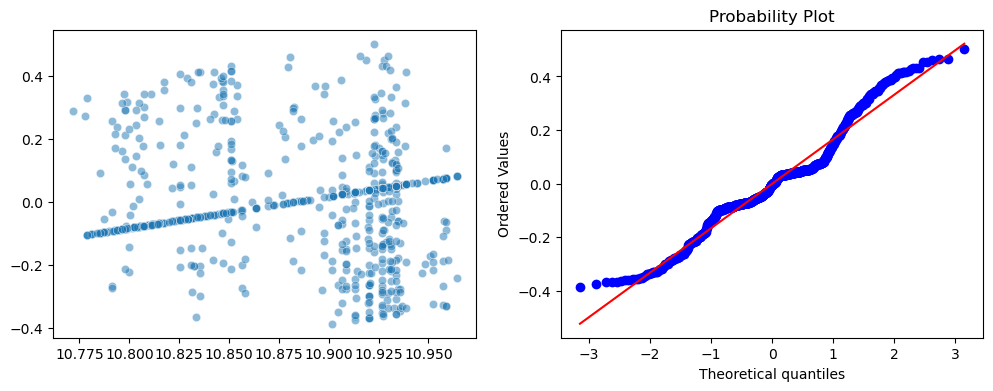

In [96]:
fig, axes = plt.subplots(1, 2, figsize = (12, 4))

# Dispersión
sns.scatterplot(x = pipeline.predict(X_train), y = errors, alpha = 0.5, ax = axes[0])

# q-q plot
_ = stats.probplot(errors, dist = 'norm', plot = axes[1])

<b>Grafica de dispersion de los errores<b>
<br>
La grafica de dispersion representa los valores de los errores en funcion de los valores predichos.<br>
El eje x representa los valores dados por el modelo y el eje y los valores de error. <br>
En este grafico es posible observar de nuevo los datos atipicos que afectan el modelo<br>
<b>Grafica de probabilidad normal Q-Q<b>
<br>
La grafica Q-Q compara la distribucion de los errores con una distribucion normal, de forma que si se sigue la distribucion normal los puntos seguiran una linea recta de lo contrario se encontraran dispersos. <br>
En este caso se observa que los datos se encuentran dispersos por lo que se infiere que los errores no siguen una distribucion normal. <br>

<b>Eliminar valores atipicos<b>

Para determinar los valores atípicos a remover puede aplicar las reglas  $$outlier > Q3 + 1.5*IQR$$

In [97]:
q1 = y_train.quantile(0.25)
q3 = y_train.quantile(0.75)
iqr = q3 - q1
threshold = q3 + 1.5 * iqr
threshold

10.882315804880689

In [98]:
y_train = y_train.loc[y_train <= threshold]
X_train = X_train.loc[y_train.index]

In [99]:
y_test = y_test.loc[y_test <= threshold]
X_test = X_test.loc[y_test.index]

In [100]:
pipeline.fit(X_train[features], y_train)

Pipeline(steps=[('scaler', StandardScaler()), ('model', LinearRegression())])

In [101]:
print('MAE:')
print('Train:', mean_absolute_error(y_train, pipeline.predict(X_train[features])))
print('Test:', mean_absolute_error(y_test, pipeline.predict(X_test[features])))
print('\nRMSE:')
print('Train:', np.sqrt(mean_squared_error(y_train, pipeline.predict(X_train[features]))))
print('Test:', np.sqrt(mean_squared_error(y_test, pipeline.predict(X_test[features]))))

MAE:
Train: 0.10033529815205142
Test: 0.09556036610358613

RMSE:
Train: 0.1295881465821576
Test: 0.12360182545319964


Es posible observar que esta medida es muy efectiva para eliminar los valores atipicos por lo que los errores disminuyen drasticamente <br>
De un MAE de 4.21 en entrenamiento a 0.31 y de de 6.15 en prueba a 0.31.<br>
De un RMSE de 24.41 en entrenamiento a 0.39 y de de 36.40 en prueba a 0.39.<br>

In [102]:
r_squared = pipeline.score(X_test[features], y_test)
print (r_squared)

0.01869776118221167


Al mismo tiempo se observa que el error $R^2$ cambia de un valor negativo a un valor positivo, lo que indica que el modelo mejora significativamente<br>
Esta medida indica que aproximadamente 58% de los datos se ajustan a un comportamiento lineal<br>

In [103]:
errors = (pipeline.predict(X_train[features]) - y_train).values

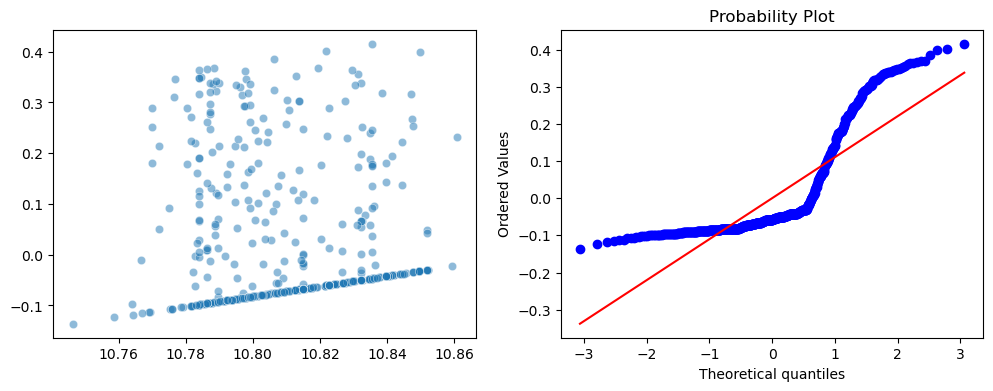

In [104]:
fig, axes = plt.subplots(1, 2, figsize = (12, 4))

# Dispersión
sns.scatterplot(x = pipeline.predict(X_train[features]), y = errors, alpha = 0.5, ax = axes[0])

# q-q plot
_ = stats.probplot(errors, dist = 'norm', plot = axes[1])
plt.show()

Tambien es posible observar la mejoria en ambas graficas especialmente en el grafico de probabilidad normal Q-Q donde los datos ahora si se ajustan a la distribucion normal<br>

### 3.3.4 Varianza constante (Homocedasticidad)


Este supuesto exige que la varianza en los errores se mantenga constante a medida que varia la variable objetivo.

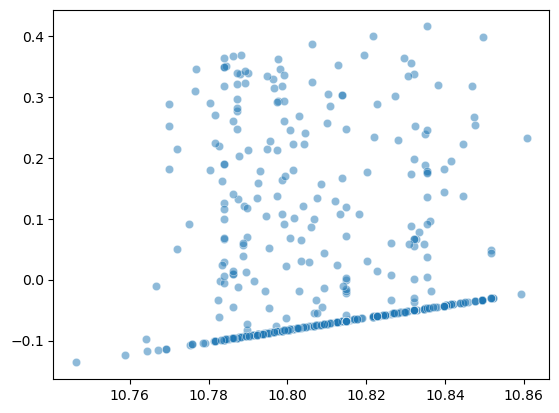

In [105]:
sns.scatterplot(x = pipeline.predict(X_train[features]), y = errors, alpha = 0.5)
plt.show()

# 4. Evaluación cuantitativa

- En cuanto a la evaluación cuantitativa, se seleccionarán métricas adecuadas para comparar y determinar el modelo óptimo. Luego, se analizará el resultado desde una perspectiva cuantitativa para abordar la siguiente cuestión: ¿Sería recomendable implementar el modelo de estimación en producción o seguir confiando en expertos para realizar la tarea?

Ambas alternativas presentan sus propias ventajas y desventajas, dependiendo de las necesidades y recursos de la empresa. Sin embargo, si la empresa cuenta con profesionales con sólidos conocimientos en análisis de datos, estadísticas y programación, podría resultar más eficiente y efectivo desarrollar y mantener modelos de estimación personalizados en lugar de depender siempre de un único modelo predefinido.

De este modo, los expertos en análisis de datos pueden tomar decisiones basadas en diversos modelos de datos a través del análisis y la comprensión de diferentes técnicas de estimación. Asimismo, pueden proporcionar información valiosa y perspectivas que contribuyan a mejorar la eficiencia, la efectividad y el rendimiento de la empresa.

- Si se decide no implementar un modelo de regresión, ¿qué otras opciones tiene la empresa y cómo debería continuar con esta tarea?

Una de las alternativas disponibles es la minería de datos, que involucra el empleo de técnicas de aprendizaje automático para descubrir patrones y relaciones ocultas en conjuntos de datos extensos. Los algoritmos de minería de datos pueden identificar relaciones complejas entre variables que no serían evidentes mediante métodos estadísticos convencionales.

Además, otra opción viable es el análisis de agrupamiento (clustering). Esta técnica se utiliza para categorizar conjuntos de datos similares en grupos o 'clusters'. Resulta beneficiosa para detectar patrones en grandes conjuntos de datos y segmentar a los clientes o usuarios en grupos específicos."

# 5. Evaluación cualitativa

El modelo cuenta con un error MAE de entrenamiento de 4.23, y de prueba de 6.15. Por otro lado, para el RMSE, se obtuvo un error de entrenamiento de 24.41, 
y uno de prueba de 36,40. Como los valores del MAE y el RMSE de entrenamiento y el de prueba son valores muy cercanos, se puede decir que el modelo no está sobreajustando (overfitting) ni subajustando (underfitting) los datos de entrenamiento. Es decir, el modelo ha aprendido lo suficiente de los datos de entrenamiento como para generalizar bien a nuevos datos que no ha visto antes.

Además, a continuación, se puede observar que las estimaciones de la variable 'Price' para el conjunto de datos nuevo se encuentran más o menos en el mismo rango de la variable original en el conjunto de datos usado para entrenar y validar el modelo.

# 7. Exportación del modelo

In [106]:
filename = 'model.joblib'

In [107]:
dump(pipeline, filename)

['model.joblib']

In [108]:
pipeline_loaded = load(filename)

# 8. Generar predicciones

In [109]:
percentage_nan = df_laptops_new[features].isna().mean() * 100
print(percentage_nan)

Weight         0.0
Ram            0.0
Ips            0.0
Ppi            0.0
TouchScreen    0.0
HDD            0.0
SSD            0.0
dtype: float64


In [110]:
df_laptops_new[features] = df_laptops_new[features].fillna(df_laptops_new[features].mean())

In [111]:
df_laptops_new['CalculatedPrice'] = pipeline_loaded.predict(df_laptops_new[features])

In [112]:
df_laptops_new['CalculatedPrice'].describe()

count    63.000000
mean     10.807448
std       0.022121
min      10.752850
25%      10.789913
50%      10.804550
75%      10.827960
max      10.850169
Name: CalculatedPrice, dtype: float64

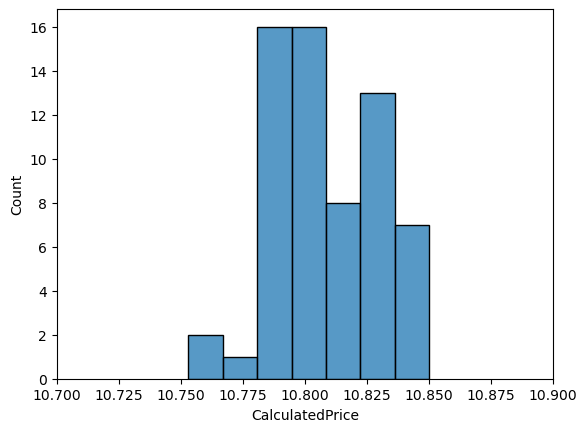

In [116]:
# Create a histogram plot of selling prices
sns.histplot(df_laptops_new['CalculatedPrice'])


plt.xlim(10.7, 10.9)

# Display the plot
plt.show()

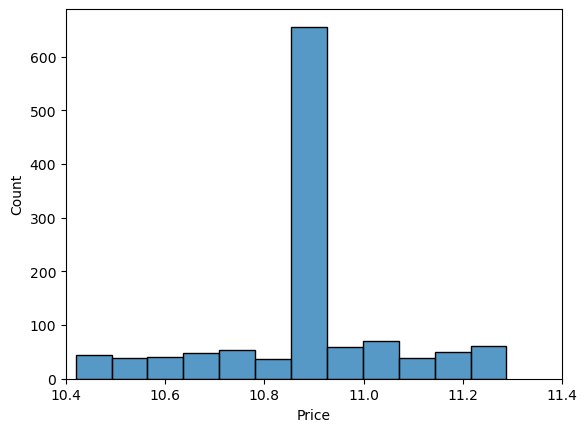

In [117]:
sns.histplot(df_laptops['Price'])
plt.xlim(10.4, 11.4)
plt.show()

#### Exportamos el nuevo dataset con los valores que el modelo predijo:

In [115]:
output_path = './data/CompuAlpes.csv'
df_laptops.to_csv(output_path, index=False, sep=',', quoting=csv.QUOTE_NONE)

# Agregar manualmente el carácter de punto y coma seguido de un salto de línea al final de cada línea en el archivo
with open(output_path, 'a') as file:
    file.write(';\n')

output_path = './data/CompuAlpesTest.csv'
df_laptops_new.to_csv(output_path, index=False, sep=',', quoting=csv.QUOTE_NONE)

# Agregar manualmente el carácter de punto y coma seguido de un salto de línea al final de cada línea en el archivo
with open(output_path, 'a') as file:
    file.write(';\n')
